In [1]:
import os
from os import path
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
from glob import glob
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import *
import torchvision
from models.generator import GeneratorRRDB
from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
# from trainer_tune import LitTrainer as LitTrainer_tune
import pytorch_lightning as pl
from models.discriminator import Discriminator
from models.feature_extractor import FeatureExtractor
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import normalized_root_mse as NRSME

print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
img_sim = ImagePair(number=100206, simulated=True, select_slices=70)
print(img_sim)
# gen_hr = subject['SR'].numpy()[0]
# gen_hr_nifty = nib.Nifti1Image(gen_hr, affine=img.subject()['HR'].affine, header=img.info()['HR'])
# nib.save(gen_hr_nifty, 'test.nii.gz')

In [3]:
path = 'output/scores'
fname_hr = 'scores_HR'

img_hr = nib.load(os.path.join(path, fname_hr+'.nii.gz'))

img_np_hr = img_hr.get_fdata()
max_val_hr = np.percentile(img_np_hr,95)
img_np_hr = img_np_hr / max_val_hr
print(img_np_hr.max())

1.1552903430525685


In [4]:
path = 'output/scores'
fname_sr = 'scores_SR'

img_sr = nib.load(os.path.join(path, fname_sr+'.nii.gz'))
header_sr = img_sr.header
img_np_sr = img_sr.get_fdata()
max_val_sr = np.percentile(img_np_sr,95)
img_np_sr = img_np_sr / max_val_sr
print(img_np_sr.max())

1.2675493121308414


1500.686789005593
0.3140319698990901
-0.3166550823836175
0.02187981015609204
0.0005981691601584793


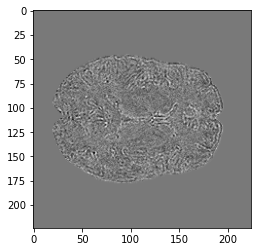

In [5]:
diff = img_np_sr-img_np_hr
plt.imshow(diff[:,:,25], cmap='gray')
diff_sum = np.sum(diff)
diff_std = np.std(diff)

print(diff_sum)
print(diff.max())
print(diff.min())
print(diff_std)
print(diff.mean())

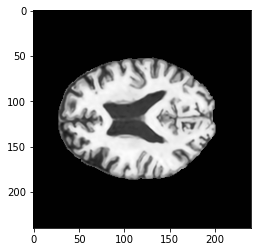

In [6]:
plt.imshow(img_np_sr[:,:,25], cmap='gray')

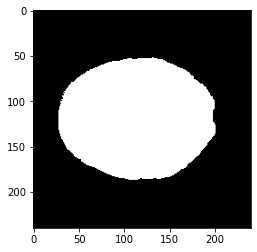

In [7]:
mask = np.ones_like(img_np_sr)
mask[np.where(img_np_sr < 1e-2)] = 0
plt.imshow(mask[:,:,25], cmap='gray')


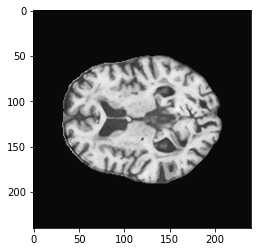

In [22]:
mask = np.ones_like(img_np_sr)
mask[np.where(img_np_sr < 1e-2)] = 0
noise = np.random.normal(loc=0, scale=0.025, size=img_np_sr.shape)
masked_noise = noise*mask
img_np_sr_noise = img_np_sr + masked_noise
plt.imshow(img_np_sr_noise[:,:,25], cmap='gray')
# plt.imshow(masked_noise[:,:,25], cmap='gray')
# plt.imshow(mask[:,:,25], cmap='gray')

In [23]:
img_np_sr_noise *= max_val_sr
affine = np.eye(4)
# affine[2,2] = 2
img_sr_noise = nib.Nifti1Image(img_np_sr_noise, affine=affine, header=header_sr)
nib.save(img_sr_noise, os.path.join(path, fname_sr + '_noise.nii.gz'))

In [15]:
def NCC(real_image, generated_image):
    """Method to compute the normalised cross correlation between two images.
    Arguments:
                real_image:       (numpy array) the real image
                predicted_image:  (numpy array) the predicted image by the model
    Returns:
                NCCScore:         (float) the normalised cross correlation score
    """
    # if the images are not the same size, raise an error
    if real_image.shape != generated_image.shape:
        raise AssertionError("The inputs must be the same size.")
    # reshape images to vectors
    u = real_image.reshape((real_image.shape[0]*real_image.shape[1]*real_image.shape[2],1))
    v = generated_image.reshape((generated_image.shape[0]*generated_image.shape[1]*generated_image.shape[2],1))
    # take the real image and subtract the mean of the real image
    u = u - u.mean(keepdims=True)
    # take the generated image and subtract the mean of the generated image
    v = v - v.mean(keepdims=True)
    # transpose the real image for multiplication
    TransposedU = np.transpose(u)
    # calculate the length of the image
    length = np.linalg.norm(u,ord=2)*np.linalg.norm(v,ord=2)
    # calculate the NCC of the real image and the generated image
    NCCScore = float(TransposedU.dot(v))/length
    # return the NCC score
    return NCCScore

def get_scores(real, gen):
    ncc = NCC(real, gen)
    print(real.shape)
    ssim = SSIM(real.squeeze(), gen.squeeze(), gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
    nrmse = NRSME(real, gen)
    return ncc, ssim, nrmse

In [13]:
ncc, ssim, nrmse = get_scores(img_np_hr, img_np_sr)
print('NCC:   {}\nSSIM:  {}\nNRMSE: {}'.format(ncc, ssim, nrmse))

(224, 224, 50)
NCC:   0.9982314477236226
SSIM:  0.9860774960494278
NRMSE: 0.05150819862910825


In [16]:
nccs = []
ssims = []
nrmses = []
for i in range(img_np_hr.shape[2]):
    # print(img_np_hr[:,:,[i]].shape)
    ncc, ssim, nrmse = get_scores(img_np_hr[:,:,[i]], img_np_sr[:,:,[i]])
    nccs.append(ncc)
    ssims.append(ssim)
    nrmses.append(nrmse)

(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f1b8c3c47c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1b8c3d2280>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1b8c40d910>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1b8c3e9af0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1b8c3763d0>],
 'means': []}

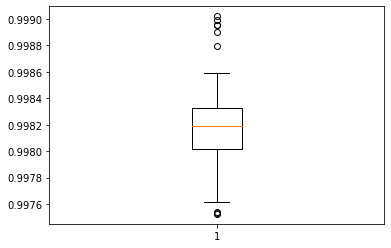

In [17]:
plt.boxplot(nccs)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1bb2196580>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1bac17d610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1b8c795d30>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1b8c557640>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1b8c790d90>],
 'means': []}

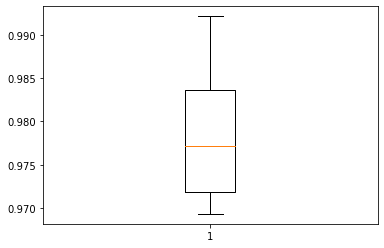

In [18]:
plt.boxplot(ssims)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1b707d34c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1b707d9af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1b707ce5e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1b707de310>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1b707e1700>],
 'means': []}

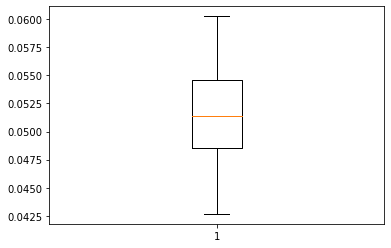

In [20]:
plt.boxplot(nrmses)

In [31]:
type(img_np_hr[0,0,0])
print(img_np_hr.mean())

0.2133276233521979
